<a href="https://colab.research.google.com/github/smomtahe/RNN_LSTM/blob/main/LSTM_RequestEveryHour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
# LSTM Long Short-Term Memory # web serving breakfast - based on time of the day (840 valyes 1 for each hour in 6 weeks - predict a week by an hour : 168 predictions )
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(1)

requests=pd.read_csv('https://raw.githubusercontent.com/smomtahe/RNN_LSTM/main/requests_every_hour.csv')
requests.head()

,Requests
0,100
1,113
2,162
3,186
4,228


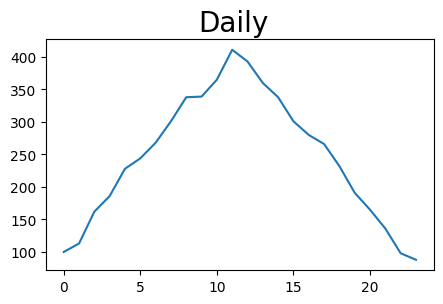

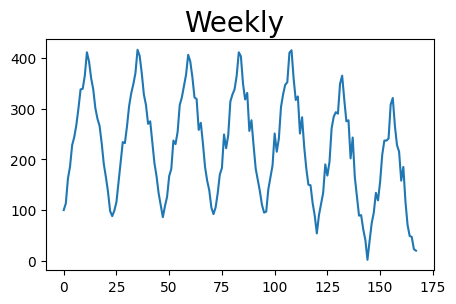

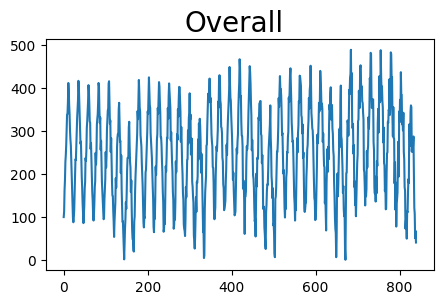

In [87]:
import matplotlib.pyplot as plt

# plot data to see trends
#daily
plt.figure(figsize=(5, 3))
plt.suptitle("Daily", fontsize=20)
plt.plot(requests.head(24))
plt.show() #cyclic
#weekly
plt.figure(figsize=(5, 3))
plt.suptitle("Weekly", fontsize=20)
plt.plot(requests.head(168))
plt.show() #seasonal
#all
plt.figure(figsize=(5, 3))
plt.suptitle("Overall", fontsize=20)
plt.plot(requests)
plt.show() #growth patters


In [93]:
# scale data using standard scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_requests = scaler.fit_transform(requests)
#print(scaled_requests.shape)

train_size = 24*7*4
lookback=24*7

# split data sequentially (not randomly)
training_requests = scaled_requests[0:train_size, :]
test_requests = scaled_requests[train_size-lookback:, :]
print(scaled_requests.shape, test_requests.shape)


(840, 1) (336, 1)


In [94]:
def create_run_dataset(data, lookback=1):
  data_x, data_y = [], []  # Initialize empty lists to store input sequences (data_x) and corresponding output values (data_y).

  for i in range(len(data) - lookback - 1):  # Iterate through the data to create samples for the RNN. The loop runs up to the index where it can create a complete sample.
    # all points from this point, looking backward up to lookback
    a = data[i:(i+lookback), 0]  # Extract a sequence of 'lookback' points starting from the current index 'i'.
    data_x.append(a)  # Append the extracted sequence to the data_x list.

    # the next point
    data_y.append(data[i + lookback, 0])  # Append the next point in the sequence (the point after the 'lookback' points) to the data_y list.

  return np.array(data_x), np.array(data_y)  # Convert the lists to NumPy arrays and return them.

train_reg_x,train_reg_y=create_run_dataset(training_requests, lookback)

train_reg_x=np.reshape(train_reg_x, (train_reg_x.shape[0],1, train_reg_x.shape[1]))
print("Shapes of X, Y:",train_reg_x.shape, train_reg_y.shape)


Shapes of X, Y: (503, 1, 168) (503,)


In [95]:
#keras models
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
tf.random.set_seed(3)

model = Sequential()
model.add(LSTM(256, input_shape=(1,lookback)))
model.add(Dense(1)) #output
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
model.summary()

# train the model
model.fit(train_reg_x, train_reg_y,epochs=5,batch_size=1,verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               435200    
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 435457 (1.66 MB)
Trainable params: 435457 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
503/503 [==============================] - 6s 7ms/step - loss: 0.1569 - mse: 0.1569
Epoch 2/5
503/503 [==============================] - 5s 10ms/step - loss: 0.0781 - mse: 0.0781
Epoch 3/5
503/503 [==============================] - 4s 8ms/step - loss: 0.0663 - mse: 0.0663
Epoch 4/5
503/503 [==============================] - 4s 7ms/step - loss: 0.0503 - mse: 0.0503
Epoch 5/5
503/503 [==================

In [97]:
# test the model
test_reg_x,test_reg_y=create_run_dataset(test_requests,lookback)
print(test_reg_x.shape,test_reg_y.shape)

test_reg_x=np.reshape(test_reg_x,(test_reg_x.shape[0],1,test_reg_x.shape[1] ))
model.evaluate(test_reg_x,test_reg_y,verbose=1)
predict_test=model.predict(test_reg_x)
predict_train=model.predict(train_reg_x)

predict_train=scaler.inverse_transform(predict_train) # back to original scale
predict_test=scaler.inverse_transform(predict_test) # back to original scale

(167, 168) (167,)
16/16 [==============================] - 0s 6ms/step


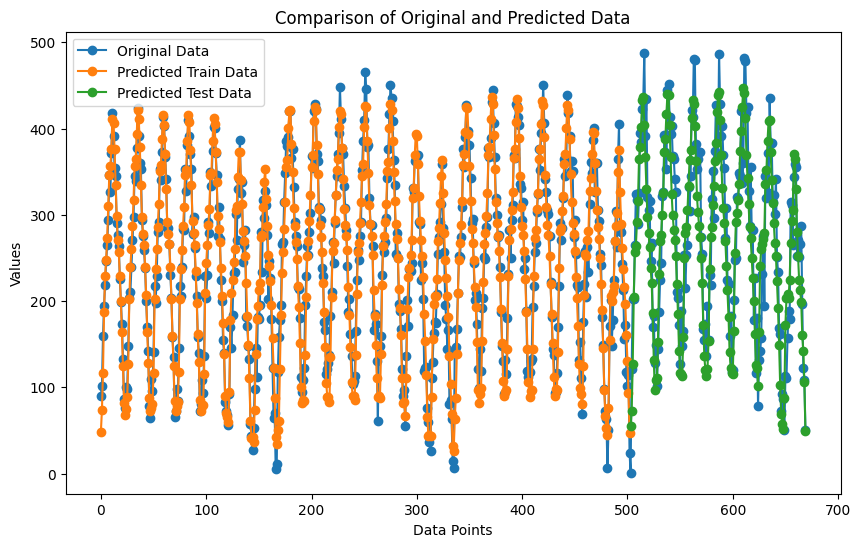

In [116]:
# Assuming you have a numpy array named orig_data
total_size = len(predict_test) + len(predict_train)

orig_data = requests.Requests.to_numpy()
orig_data = orig_data.reshape(len(orig_data), 1)

orig_plot = np.empty((total_size, 1))
orig_plot[:, :] = np.nan
orig_plot[0:len(orig_data)-lookback-2, :] = orig_data[lookback:-2, :]

predict_train_plot = np.empty((total_size, 1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_train), :] = predict_train

predict_test_plot = np.empty((total_size, 1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_train):total_size, :] = predict_test

# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(orig_plot, label='Original Data', marker='o')
plt.plot(predict_train_plot, label='Predicted Train Data', marker='o')
plt.plot(predict_test_plot, label='Predicted Test Data', marker='o')

plt.title('Comparison of Original and Predicted Data')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()
plt.show()


In [112]:
# forcasting future service loads
curr_input=test_reg_x[-1,:].flatten()
predict_for=24*7
for i in range (predict_for):
  this_input=curr_input[-lookback:]
  this_input = this_input.reshape((1, 1, lookback))
  this_prediction = model.predict(this_input)
  curr_input = np.append(curr_input, this_prediction.flatten())


1/1 [==============================] - 0s 28ms/step


In [114]:
predict_on_future=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))
predict_on_future=scaler.inverse_transform(predict_on_future)
print(predict_on_future[:10])

[[ 49.23824439]
 [ 51.11808936]
 [ 71.04522955]
 [ 93.19989932]
 [150.81095635]
 [214.79635123]
 [252.53933515]
 [259.21021421]
 [268.21482574]
 [311.44779991]]


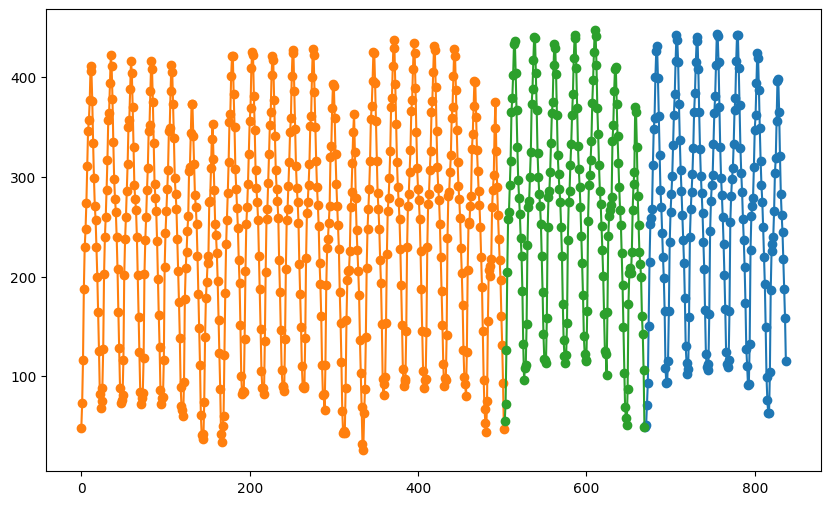

In [119]:
total_size = len(predict_on_future)+len(predict_test) + len(predict_train)

predict_train_plot = np.empty((total_size, 1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_train), :] = predict_train

predict_test_plot = np.empty((total_size, 1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_train):len(predict_train)+len(predict_test) , :] = predict_test

predict_future_plot = np.empty((total_size, 1))
predict_future_plot[:, :] = np.nan
predict_future_plot[len(predict_train)+len(predict_test):total_size, :] = predict_on_future

# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(predict_future_plot, label='Predicted Future Data', marker='o')
plt.plot(predict_train_plot, label='Predicted Train Data', marker='o')
plt.plot(predict_test_plot, label='Predicted Test Data', marker='o')
plt.show()
